In [2]:
import numpy as np
import mne


sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = sample_data_folder / "MEG" / "sample" / "sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(tmax=60).load_data()

Opening raw data file C:\Users\ashish\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


# The Events and Annotations data structures
both the Events and Annotations data structures serve the same purpose:

they provide a mapping between times during an EEG/MEG recording and a description of what happened at those times.

1. **Units**:: the Events data structure represents the when in terms of samples, whereas the Annotations data structure represents the when in seconds.

2. **Limits on the description**: the Events data structure represents the what as an integer “Event ID” code, whereas the Annotations data structure represents the what as a string.

3. **How duration is encoded**: Events in an Event array do not have a duration (though it is possible to represent duration with pairs of onset/offset events within an Events array), whereas each element of an Annotations object necessarily includes a duration (though the duration can be zero if an instantaneous event is desired).

4. **Internal representation**: Events are stored as ordinary Numpy_array ,whereas Annotations is a list -like class defined in MNE-Python.

# What is a STIM Channel?

A stim channel is a channel that does not receive signals from an EEG,MEG or other sensor.Instead,STIM channels record voltages that are generally time locked to experimental events.

Using matplotlib as 2D backend.


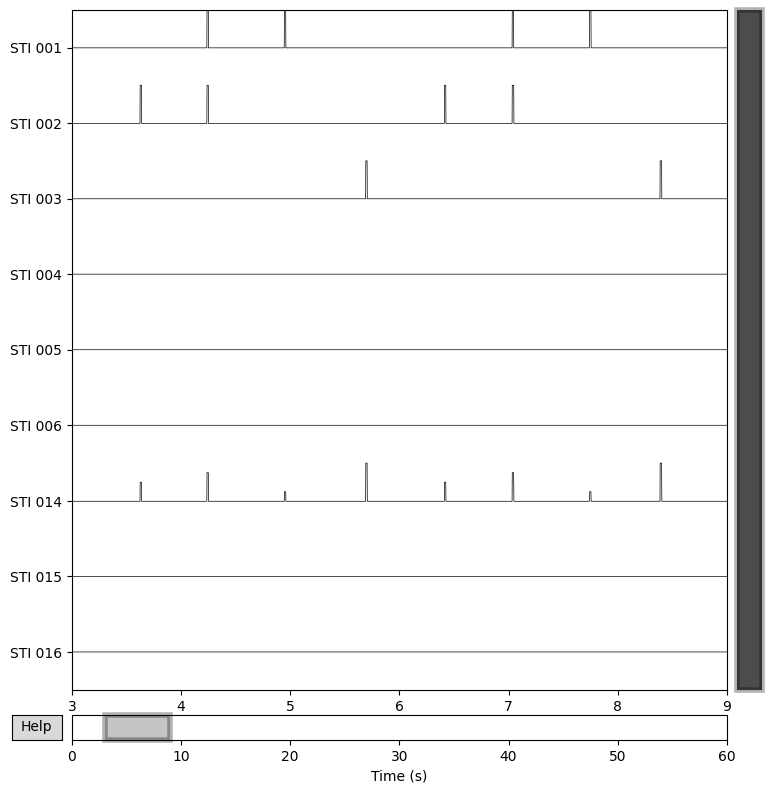

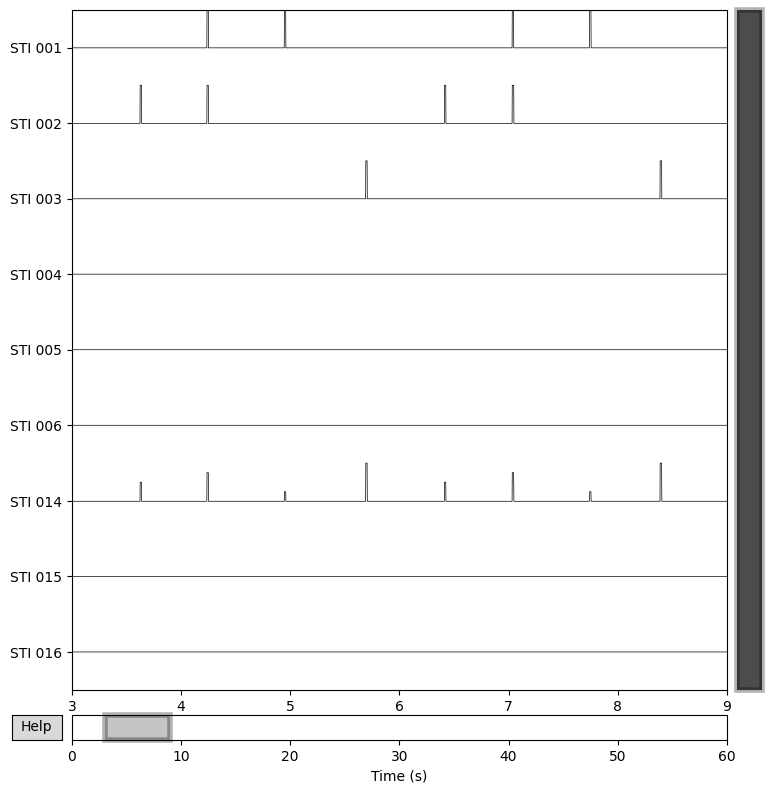

In [3]:
raw.copy().pick(picks="stim").plot(start=3,duration=6)

You can see that STI 014 (the summation channel) contains pulses of different magnitudes whereas pulses on other channels have consistent magnitudes.

You can also see that every time there is a pulse on one of the other STIM channels, there is a corresponding pulse on STI 014.

# Converting a STIM channel signal to an Events array

If your data has events recorded on a STIM channel, you can convert them into an events array using **find_events**


he sample number of the onset (or offset) of each pulse is recorded as the event time, the pulse magnitudes are converted into integers, and these pairs of sample numbers plus integer codes are stored in NumPy arrays


the function requires only the Raw object, and the name of the channel(s) from which to read events:


In [4]:
events=mne.find_events(raw,stim_channel="STI 014")
print(events[:5]) # show the first 5

86 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


If you don’t provide the name of a STIM channel, find_events will first look for MNE-Python config variables for variables MNE_STIM_CHANNEL, MNE_STIM_CHANNEL_1, etc. If those are not found, channels STI 014 and STI101 are tried, followed by the first channel with type “STIM” present in raw.ch_names

find_events has several options, including options for aligning events to the onset or offset of the STIM channel pulses, setting the minimum pulse duration, and handling of consecutive pulses (with no return to zero between them). 

# Reading embedded events as Annotations

Some EEG/MEG systems generate files where events are stored in a seperate data array rather than as pulses on one or more STIM channels.

EX:- EEGLAB format stores events as collection of arrays in the .set file .When reading those files,MNE-Python will automatically convert the stored events into an **Annotations** object and store it as the **Anotations** attribute of the **Raw** object.

In [5]:
testing_data_folder=mne.datasets.testing.data_path()
eeglab_raw_file=testing_data_folder/"EEGLAB"/"test_raw.set"

eeglab_raw=mne.io.read_raw_eeglab(eeglab_raw_file)
print(eeglab_raw.annotations)

Using default location ~/mne_data for testing...
Dataset testing version 0.0 out of date, latest version is 0.152


 39%|###############3                       | 423M/1.08G [06:21<15:08, 718kB/s]Failed to download 'mne-testing-data-0.152.tar.gz'. Will attempt the download again 2 more times.
 39%|##############9                       | 423M/1.08G [06:24<09:53, 1.10MB/s]
100%|#####################################| 1.08G/1.08G [00:00<00:00, 1.03TB/s]
Untarring contents of 'C:\Users\ashish\mne_data\mne-testing-data-0.152.tar.gz' to 'C:\Users\ashish\mne_data'


Download complete in 11m04s (1025.8 MB)
Reading C:\Users\ashish\mne_data\MNE-testing-data\EEGLAB\test_raw.fdt
<Annotations | 154 segments: rt (74), square (80)>


The core data within an **Annotations** object is accessible through three of its attributes: **onset**,**duration**, and **description** . Here we can see that there were 154 events stored in the EEGLAB file, they all had a duration of zero seconds ,there were two different types of events, and the first event occured about 1 second after the recording began:

In [6]:
print(len(eeglab_raw.annotations))
print(set(eeglab_raw.annotations.duration))
print(set(eeglab_raw.annotations.description))
print(eeglab_raw.annotations.onset[0])

154
{0.0}
{'square', 'rt'}
1.000068


# Converting between Events arrays and Annotations objects

You can easily convert  between the two formats as needed.

Events array is needed for epoching continuous data, or because you want to take the advantage of the "annotation-aware" capability of some functions,which automatically omit spans of data if they overlap with certain annotations

To convert an Annotations object to an Events array, use the function mne.events_from_annotations on the Raw file containing the annotation.

his function will assign an integer Event ID to each unique element of raw.annotations.description, and will return the mapping of descriptions to integer Event IDs along with the derived Event array.




In [7]:
events_from_annot,event_dict=mne.events_from_annotations(eeglab_raw)
print(event_dict)
print(events_from_annot[:5])

Used Annotations descriptions: ['rt', 'square']
{'rt': 1, 'square': 2}
[[128   0   2]
 [217   0   2]
 [267   0   1]
 [602   0   2]
 [659   0   1]]


If you want to control which integers are mapped to each unique description value, you can pass a dict specifying the mapping as the event_id parameter of events_from_annotations

In [9]:
custom_mapping = {"rt": 77, "square": 42}
(events_from_annot, event_dict) = mne.events_from_annotations(
    eeglab_raw, event_id=custom_mapping
)
print(event_dict)
print(events_from_annot[:5])

Used Annotations descriptions: ['rt', 'square']
{'rt': 77, 'square': 42}
[[128   0  42]
 [217   0  42]
 [267   0  77]
 [602   0  42]
 [659   0  77]]


To make the opposite conversion(from an Events array to an **Annotations** object),you can create a mapping from the Integer Event ID to string descriptions,use **annotations_from_events** to construct the Annotations object, and call the **set_annotations** method to add the annoations to the **Raw** object.

We also need to pass in the **orig_time** parameter so that the onsets are properly aligned relative to the start of the recordings.

In [12]:
mapping = {
    1: "auditory/left",
    2: "auditory/right",
    3: "visual/left",
    4: "visual/right",
    5: "smiley",
    32: "buttonpress",
}
annot_from_events = mne.annotations_from_events(
    events=events,
    event_desc=mapping,
    sfreq=raw.info["sfreq"],
    orig_time=raw.info["meas_date"],
)
raw.set_annotations(annot_from_events)

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


Now, the annotations will appear automatically when plotting the raw data and will be color coded by their labels value:



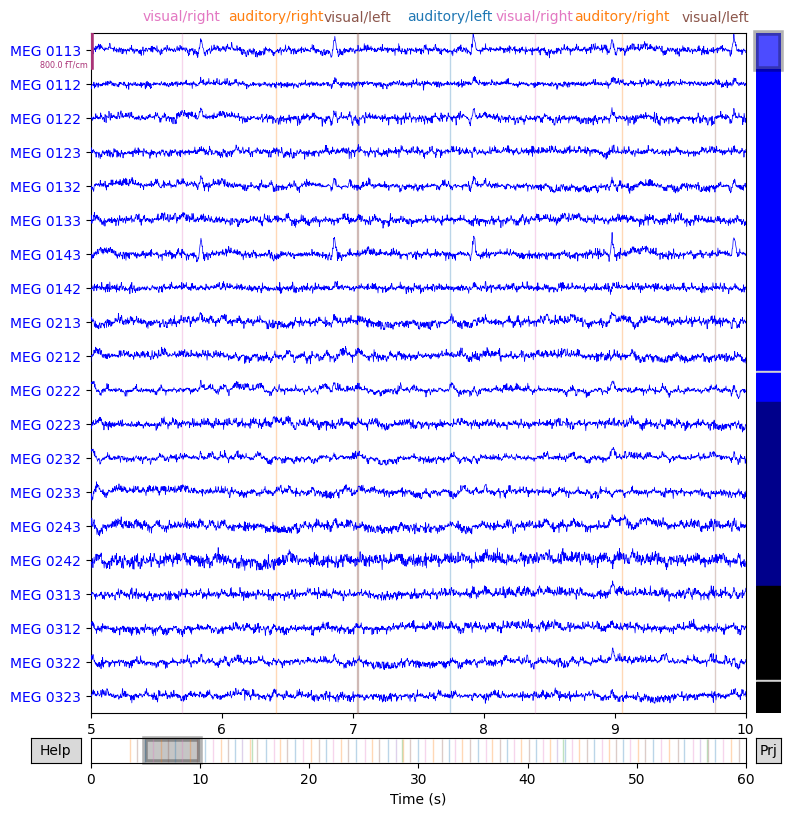

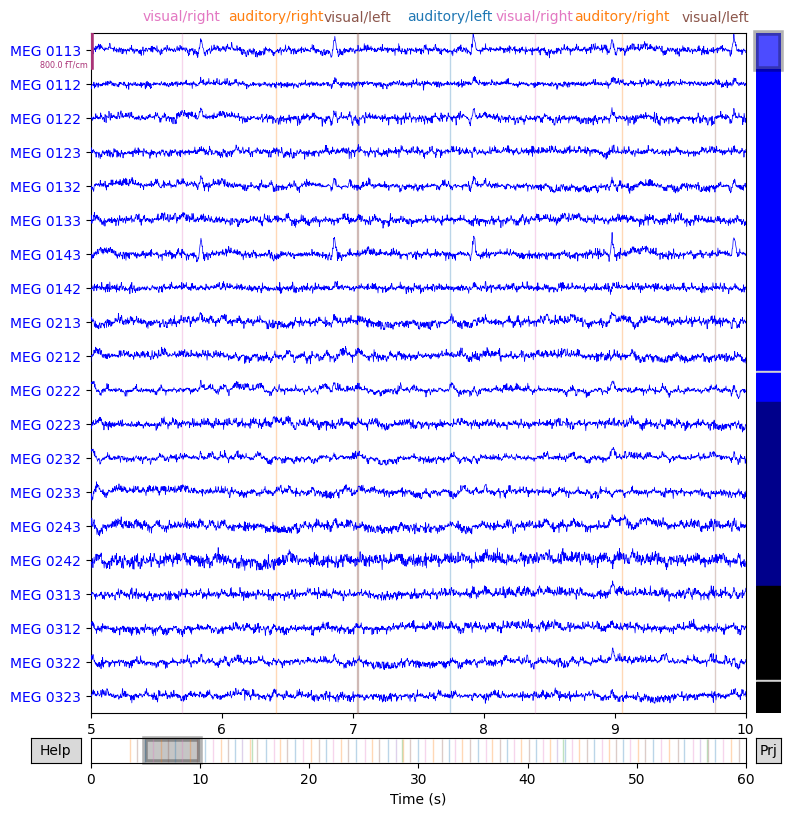

In [13]:
raw.plot(start=5,duration=5)

ou can generate equally-spaced events from an Annotations object using the chunk_duration parameter of events_from_annotation

In [14]:
# create the REM annotations
rem_annot = mne.Annotations(onset=[5, 41], duration=[16, 11], description=["REM"] * 2)
raw.set_annotations(rem_annot)
(rem_events, rem_event_dict) = mne.events_from_annotations(raw, chunk_duration=1.5)

Used Annotations descriptions: ['REM']
